In [181]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [183]:
def simulate_lorenz(initial_state, steps = 500, dt= 0.01, sigma = 10.0, rho = 28.0, beta = 8.0/3.0):
    def lorenz_system(state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho - z) - y
        dzdt = x * y - beta * z
        return np.array([dxdt, dydt, dzdt])
    state = np.array(initial_state)
    trajectory = []
    for _ in range(steps):
        trajectory.append(state.copy())
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + 0.5 * dt * k1)
        k3 = lorenz_system(state + 0.5 * dt * k2)
        k4 = lorenz_system(state + dt * k3)
        state += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return np.array(trajectory)
        

In [185]:
def create_graph_lorenz(trajectory):
    edge_index = []
    for i in range(len(trajectory)-1):
        edge_index.append([i, i+1])
    edge_index = torch.tensor(edge_index, dtype = torch.long).t().contiguous()
    x = torch.tensor(trajectory, dtype = torch.float)

    data = Data(x=x, edge_index = edge_index)
    return data

In [187]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(output_dim)

    def create_full_graph(self, x):
        n = x.size(0)
        edge_index = torch.stack([
            torch.repeat_interleave(torch.arange(n), n),
            torch.tile(torch.arange(n), (n,))
        ]).to(x.device)
        return edge_index
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float()
        edge_index = self.create_full_graph(x)
        gnn_x = self.conv1(x, edge_index).relu()
        gnn_x = self.norm1(gnn_x)
        gnn_x = self.conv2(gnn_x, edge_index)
        gnn_x = self.norm2(gnn_x)

        fc_x = self.fc1(x).relu()
        fc_x = self.fc3(fc_x).relu()
        fc_x = self.fc3(fc_x)

        return (gnn_x+ fc_x)/2

In [189]:
class KoopmanModel(torch.nn.Module):
    def __init__(self, input_dim, koopman_dim):
        super(KoopmanModel, self).__init__()
        self.encoder = GNN(input_dim, koopman_dim, koopman_dim)
        self.koopman_matrix = torch.nn.Parameter(torch.eye(koopman_dim))
        self.decoder = GNN(koopman_dim, koopman_dim, input_dim)

    def forward(self, data):
        koopman_space = self.encoder(data)
        next_koopman_space = koopman_space @ self.koopman_matrix
        new_data = Data(x=next_koopman_space, edge_index = data.edge_index)
        new_state = self.decoder(new_data)
        return new_state

In [191]:
def auto_encoding_loss(decoded, original_states):
    return F.mse_loss(decoded, original_states)

def prediction_loss(koopman_space, koopman_matrix, decoder, data, T):
    predicted = koopman_space.clone()
    for _ in range(T-1):
        predicted = predicted @ koopman_matrix
    decoded_pred = decoder(Data(x=predicted, edge_index=data.edge_index))
    return F.mse_loss(decoded_pred, data.x)

def metric_loss(koopman_space, original_space):
    distances_koopman = torch.cdist(koopman_space, koopman_space, p=2)
    distances_original = torch.cdist(original_space, original_space, p=2)
    return F.l1_loss(distances_koopman, distances_original)


def total_loss(model, data, T, lambda1=1.0, lambda2=1.0):
    koopman_space = model.encoder(data)
    decoded = model.decoder(Data(x=koopman_space, edge_index=data.edge_index))
    
    ae_loss = auto_encoding_loss(decoded, data.x)
    pred_loss = prediction_loss(koopman_space, model.koopman_matrix, model.decoder, data, T)
    m_loss = metric_loss(koopman_space, data.x)
    print(f"AE Loss: {ae_loss}, Prediction Loss {pred_loss}, Total Loss {m_loss}")

    return ae_loss + lambda1 * pred_loss + lambda2 * m_loss 

In [193]:
def train_model(model, dataset, epochs = (10),lambda1=1.0, lambda2=1.0):
    optimizer = Adam(model.parameters(), lr = 0.005)
    model = model.to(device)
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            prediction = model(data)
            loss = total_loss(model, data, T = len(data.x),  lambda1=lambda1, lambda2=lambda2)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(dataset)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss {avg_loss}")
    plt.plot(range(epochs), train_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.show()

In [195]:
initial_state = [1.0, 0.0, 0.0]
lorenz_trajectory = simulate_lorenz(initial_state)
dataset = [create_graph_lorenz(lorenz_trajectory) for _ in range(100)]

In [197]:
model = KoopmanModel(input_dim = 3, koopman_dim = 3).to(device)

AE Loss: 307.3162841796875, Prediction Loss 307.3162841796875, Total Loss 9.030482292175293
AE Loss: 307.0213623046875, Prediction Loss 304.8095397949219, Total Loss 9.023598670959473
AE Loss: 306.7323303222656, Prediction Loss 306.7196350097656, Total Loss 9.015558242797852
AE Loss: 306.4549560546875, Prediction Loss 301.7613220214844, Total Loss 9.007461547851562
AE Loss: 306.18701171875, Prediction Loss 277.2607116699219, Total Loss 8.99846076965332
AE Loss: 305.9338684082031, Prediction Loss 304.2391357421875, Total Loss 8.988388061523438
AE Loss: 305.6993713378906, Prediction Loss 276.1202697753906, Total Loss 8.982111930847168
AE Loss: 305.4694519042969, Prediction Loss 276.66705322265625, Total Loss 8.974943161010742
AE Loss: 305.2440490722656, Prediction Loss 277.5481262207031, Total Loss 8.967272758483887
AE Loss: 305.0184020996094, Prediction Loss 306.5267333984375, Total Loss 8.9586181640625
AE Loss: 304.78619384765625, Prediction Loss 308.44964599609375, Total Loss 8.950071

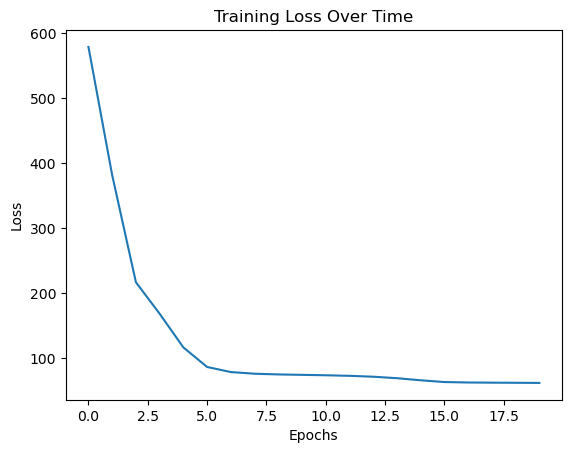

In [199]:
train_model(model, dataset, epochs = 20)